Evaluate various CNN models on widely known datasets
Support for the article: Radu Dogaru, Ioana Dogaru, "RD-CNN: A Compact and Efficient Convolutional Neural Net for Sound Classification", accepted at ISETC 2020

Run CELL1 or CELL2 for the specific dataset
(some classic sets or ESC50 "spectral" images resulted from RDT processing)  
Then introduce the specific model name (.h5 files and/or ESC datasets must be previously uploaded in the Files tab)


Run CELL3 and 4 (Runtime set to "NONE" allows evaluate a latency performance closer to a restricted CPU platform)

Run CELLS 5 and 6 to see prediction examples and detailed performance metrics.

Run CELL 7 (RDT based image processor) and CELL 8 for prediction of the model given an input sound signal (.wav) file

Copyright - Radu and Ioana Dogaru,
Last update Oct. 20, 2020
Revised March 30, 2022 - to operate with the actual version of Tensorflow ; 2025 revision (downgrade to TF 2.15 for compatibility thus making possible its run on the actual environment of Colab)

In [7]:
# Clone the git to access various files
!git clone https://github.com/radu-dogaru/NL-CNN-RDT-based-sound-classification-
# Downgrade to tf 2.15 in order to ensure compatibility with files saved in 2020
!pip install tensorflow==2.15

Cloning into 'NL-CNN-RDT-based-sound-classification-'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 51 (delta 22), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 25.67 MiB | 7.09 MiB/s, done.
Resolving deltas: 100% (22/22), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.8 MB/s eta 0:00:00
   ━

In [1]:
cd NL-CNN-RDT-based-sound-classification-/

/content/NL-CNN-RDT-based-sound-classification-


In [2]:
# CELL 1 Datasets from Keras - MNIST, F_MNIST, CIFAR
# Not necessary to run for sound recognition (used only to test the classifier)
# Run next cell to load spectrograms data (generated with 2D - RDT)
#---------------------------------------------------

import tensorflow
import numpy as np
import keras

dataset='cifar10' # mnist or f-mnist or cifar10
reduced=0
dformat='channels_last'

from tensorflow.keras.datasets import mnist, cifar10, cifar100, fashion_mnist

if dataset=='mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data() # incarca date nescalate
elif  dataset=='cifar10':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data() # incarca date nescalate
elif  dataset=='cifar100':
    (x_train, y_train), (x_test, y_test) = cifar100.load_data() # incarca date nescalate
elif dataset=='f-mnist':
    (x_train, y_train), (x_test, y_test) =  fashion_mnist.load_data()

if (np.ndim(x_train)==3):   # E.g.  MNIST or F-MNIST
    x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1])
    x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] )
# place a  1 in the end to keep it compatible with kernel in conv2d
# scaling in ([0,1])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255
inp_chan=np.shape(x_train)[3]
print('Number of input channels in image:', inp_chan)
num_classes=np.max(y_train)+1
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]


# one can choose a lower numbers of training samples (when GPU MEM is overloaded)
if reduced>0:
    Ntr1=reduced
    x_train=x_train[0:Ntr1,:,:,:]
    y_train=y_train[0:Ntr1]
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 3s 0us/step
Number of input channels in image: 3


In [3]:
# CELL2 - DATASETS ("spectral" images) OBTAINED from RDT transform
import scipy.io as sio
import numpy as np


dict=sio.loadmat('esc50-2d-214-7-0-0.mat')


x_train=dict['x_train']
x_test=dict['x_test']

y_train=dict['y_train']
y_test=dict['y_test']

'''
#------------- aici posibil divizare dim intrare
dwn=2
x_train=x_train[:,0:128:dwn,0:128:dwn,:]
x_test=x_test[:,0:128:dwn,0:128:dwn,:]
'''
#----------------------------------------------------

# --- cele de mai jos pentru a corecta o eroare de salvare in format Matlab

#y_train=np.reshape(y_train,np.shape(y_train)[1])
#y_test=np.reshape(y_test,np.shape(y_test)[1])

num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]
num_classes=np.shape(y_train)[1]


In [4]:
# CELL 3 - load and display the model summary
from tensorflow import keras

# "Upload" model file
#mod=keras.models.load_model('cifar_90_90.h5')
#mod=keras.models.load_model('cifar_small_90_05.h5')


mod = keras.models.load_model('esc50_2d_214_7_0_0_76_50.h5')
mod.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (None, 214, 7, 40)        640       
                                                                 
 activation_34 (Activation)  (None, 214, 7, 40)        0         
                                                                 
 conv2d_74 (Conv2D)          (None, 214, 7, 40)        24040     
                                                                 
 activation_35 (Activation)  (None, 214, 7, 40)        0         
                                                                 
 conv2d_75 (Conv2D)          (None, 214, 7, 40)        24040     
                                                                 
 batch_normalization_13 (Ba  (None, 214, 7, 40)        160       
 tchNormalization)                                               
                                                     

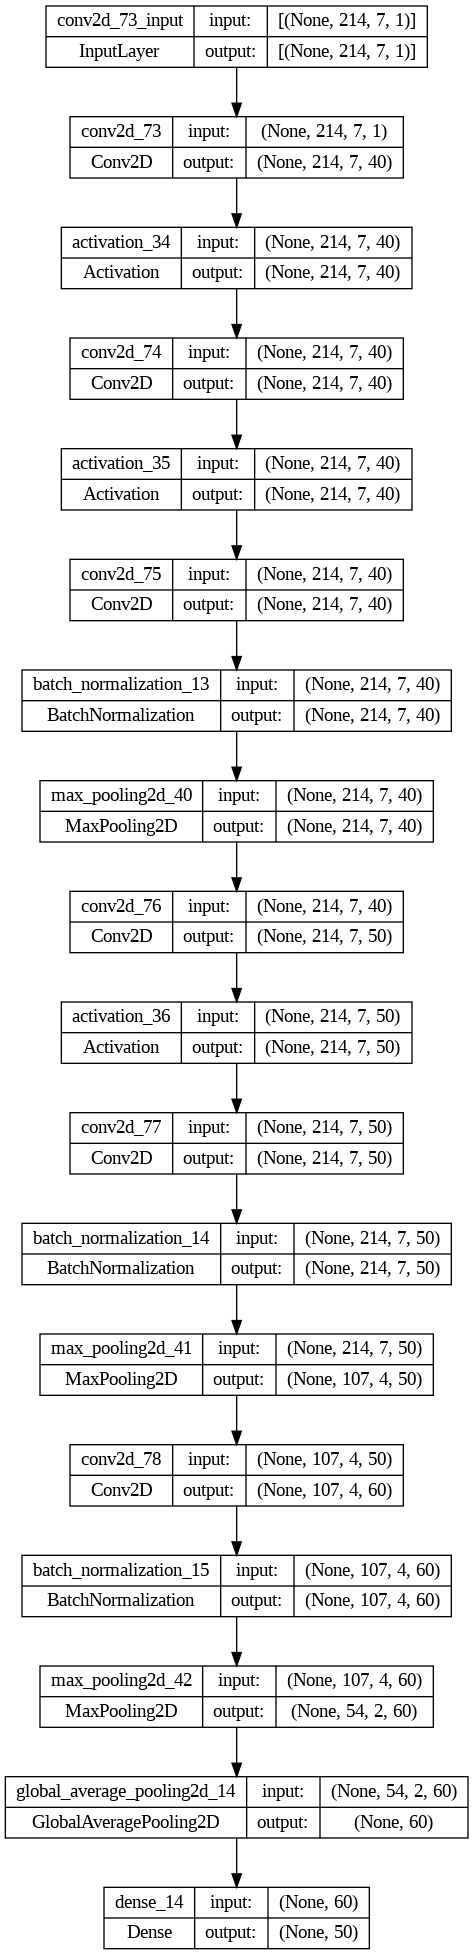

In [5]:

# plot the model
from tensorflow.keras.utils import plot_model
plot_model(mod, show_shapes='True', to_file='model.png')

In [6]:
# CELL 4 - evaluate the loaded model
import time as ti
t1=ti.time()
score = mod.evaluate(x_test, y_test, verbose=0)
t2=ti.time()
print('Test accuracy:', score[1])
print ('Time for test set : ',t2-t1)
print('Latency (per input sample):', 1000*(t2-t1)/np.shape(x_test)[0], 'ms')


Test accuracy: 0.7649999856948853
Time for test set :  10.583768844604492
Latency (per input sample): 26.45942211151123 ms


/tmp/ipython-input-3312487935.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  selectia=int(np.shape(x_test)[0]*np.random.rand(1))  #


Original label : 46.0
1/1 [==============================] - 0s 178ms/step
Recognized label:  46


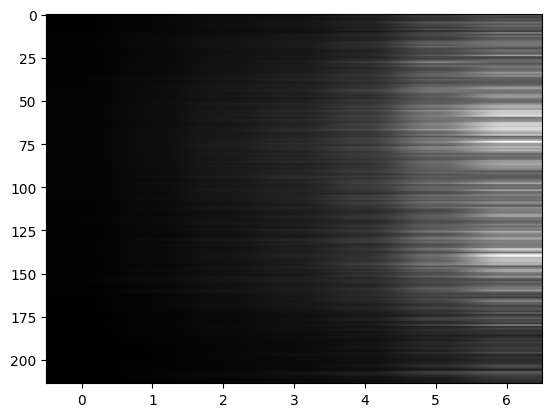

In [7]:
# CELL 5 Random samples prediction

selectia=int(np.shape(x_test)[0]*np.random.rand(1))  #

img1=x_test[selectia,:,:,:]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
if np.shape(x_train)[3]==1:
  plt.imshow(img1[:,:,0],cmap='gray', aspect='auto')
elif np.shape(x_train)[3]==3:
  plt.imshow(img1)

label=np.dot(y_test[selectia,:],1+np.array(range(num_classes)).T)
print('Original label :', label)
z=mod.predict(x_test[selectia:selectia+1,:,:,:])
print('Recognized label: ',1+np.argmax(z))



In [8]:
# CELL 6 -  Evaluate performance metrics
#
#----------------------------------------------------------------

labels=(np.dot(y_test,np.array(range(num_classes)).T)).astype('int16')
pred= mod.predict(x_test)
predicted_class_indices=np.argmax(pred,axis=1)
from sklearn.metrics import classification_report, confusion_matrix
C=confusion_matrix(predicted_class_indices,labels)
print (C)
print('Classification Report')
print(classification_report(labels,predicted_class_indices ))


13/13 [==============================] - 5s 395ms/step
[[ 4  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0  8  0]
 [ 0  0  0 ...  0  0  5]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.92      0.96        13
           2       0.75      0.60      0.67         5
           3       0.60      0.60      0.60         5
           4       1.00      0.89      0.94         9
           5       0.89      0.80      0.84        10
           6       0.89      1.00      0.94         8
           7       0.57      0.80      0.67        10
           8       0.73      0.80      0.76        10
           9       0.88      0.78      0.82         9
          10       1.00      0.78      0.88         9
          11       0.70      1.00      0.82         7
          12       0.50      0.75      0.60         8
          

Next code gives the implementation of the RDT spectral image processors and demonstrates its use in a complete chain of prediction:

sound-file in .wav format --> RDT spectral image ---> NL-CNN label predictor

Some .wav samples can be loaded from the GIT

In [9]:
# needed to install a package for reading sounds
!pip install soundfile

In [10]:
# CELL 7
#Implementation of RDT based spectral image processor
# Coyright Radu & Ioana DOGARU - 17 July 2020; 20 Oct. 2020
# Code associated with papers:

# R. Dogaru and I. Dogaru, "A low complexity solution for epilepsy detection using an improved version
# of the reaction-diffusion transform," 2017 5th International Symposium on Electrical and Electronics Engineering
# (ISEEE), Galati, 2017, pp. 1-6.

# I. Dogaru, D. Stan and R. Dogaru, "Compact Isolated Speech Recognition on Raspberry-Pi based on
# Reaction Diffusion Transform," 2019 6th International Symposium on Electrical and Electronics Engineering
# (ISEEE), Galati, Romania, 2019, pp. 1-4.

# R. Dogaru and I. Dogaru, "RD-CNN: A Compact and Efficient Convolutional Neural Net for Sound Classification", in
# Proceedings ISETC, 2020.

# If you find this code useful in your research, please consider citing the above papers
#----------------------------------------------------------------------
import time as ti
import soundfile as sf
import numpy as np

def read_signal(wfile):
    data, samplerate = sf.read(wfile)
    N=np.shape(data)[0]
    data=np.reshape(data.T,(1,N))
    # iesirea este in formatul acceptat de functiile RDT
    return data

def NRDT(signal, w, flag, channels):
# Signal is an NP.ARRAY - format [1,N]
# channells is a list of delays
#
#----------- channels = 1 2 5 ... 9

    signal=signal.astype('float32') # may help
    Nsamples=np.size(signal,1)
    delmax=w/4 #  delay should be no more than w/4 (w usually is a power of 2)
    res=np.where(channels<=delmax)
    #print(res)
    channels=channels[res]  # remove chanells not satisfyiong this condition.
    m=np.shape(channels)[0]


    spectrograms=Nsamples//w # The number of spectrograms computed
    Samples=spectrograms*w # The number of samples used to compute the spectrograms.The other samples are discarded
    matrix=np.reshape(signal[0,0:Samples],(spectrograms,w)) # each line is one to be submited for computation of spectrogram


    spectrum=np.zeros((m,spectrograms))
    for i in range(0,spectrograms):
        values=matrix[i,:] # the whole line
        for k in range(0,m):
            delay=channels[k]  # delays
            t=np.array(range(delay,w-delay-1))
            difus=np.abs(values[t-delay]+values[t+delay]-2*values[t])
            if flag==0:
                spectrum[k,i]=np.mean(difus)/4
            elif flag==1:
                spectrum[k,i]=np.mean(difus/(np.abs(values[t-delay])+np.abs(values[t+delay])+2*np.abs(values[t])+1e-12))/4
    return spectrum


def get_features_nrdt(filename, M, w, flag, prag, chan):
# Implements "spectral image (F3org)" using RDT applied on  M  segments, W window size .
# Gives errors if the number of windows per segment is smaller than  1
# Needs tuning of M, w.
# chan - a list of delays for the "spectral" channels
# prag - it is usually taken 0 (in special cases larger)
# flag - 0 (normal) / 1 (scaled RDT)
#=========================================================================
  signal=read_signal(filename)
  # signal [1,N] este scalaat -1,1
  delmax=w/4 #  ne asiguram ca delay-ul maxim nu depaseste w/4 (w este de regula putere a lui 2)
  res=np.where(chan<=delmax)
  #print(res)
  channels=chan[res]
  m=np.shape(chan)[0]

  #print('Threshold for sample removal', prag )
  #print('Full length of original signal is : ',np.size(signal))
  t1=ti.time()
  res=np.where(np.abs(signal)>=prag)
  semnal=signal[0,res[1]]
  semnal=np.reshape(semnal.T,(1,np.shape(semnal)[0]))

  Features=np.zeros((M*m))
  Feat_spec=np.zeros((M,m))
  Npsgm=np.shape(semnal)[1] // M # The number of samples per each segment
  print('Nsegm=',Npsgm, 'Windows per each segment: ', Npsgm // w)

  for isgm in range(0,M): # Calculate the RDT on each segment of the signal
      ssegment=np.reshape(semnal[0,isgm*Npsgm:(isgm+1)*Npsgm],(1,Npsgm))
      spectrum=NRDT(ssegment,w,flag,chan)
      mediumRDT=sum(np.transpose(spectrum)) # The medium spectrogram is the sum on columns of the transposed spectrum matrix
      Features[isgm*m:(isgm+1)*m]=mediumRDT # The feature vector for the signal to be recognized
      Feat_spec[isgm,:]=mediumRDT.T
  t2=ti.time()

  return Features, Feat_spec


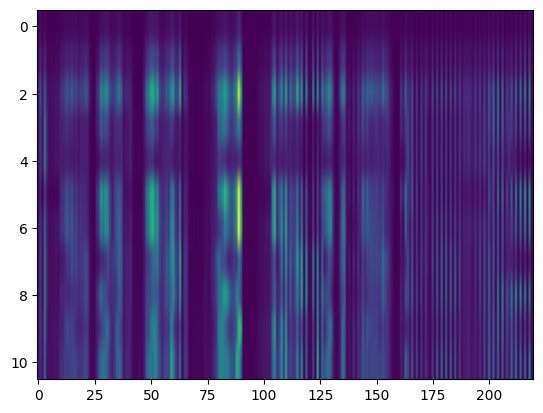

In [11]:
# Example of computing a spectral image using NLRDT (here for the whole signal)
import matplotlib.pyplot as plt
my_signal_file='2-32515-A-4.wav'
signal=read_signal(my_signal_file)
linspec=np.array([2, 4, 8, 16, 20, 32, 50, 64, 100, 128, 200, 300])
spect=NRDT(signal, 1000, 0, linspec)
plt.imshow(spect, aspect='auto')

Nsegm= 1030 Windows per each segment:  1
RDT Processing time:  0.30054545402526855  seconds
1/1 [==============================] - 0s 50ms/step
Recognized label for signal:  2-32515-A-4.wav  is:  4  It should be equal with the figure before .wav 
Recognition time on CPU:  0.1655445098876953
Total recognition time:  0.46608996391296387  seconds
You may hear the sound - next is its image spectrogram


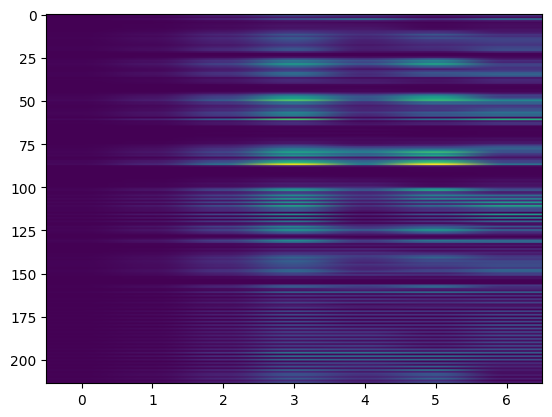

In [12]:
# CELL 8
# PREDICTION OF THE TRAINED MODEL WITH A GIVEN SIGNAL FILE (here signals from the dataset are used
# but others may be used instead)

import time as ti
t1=ti.time()
my_signal_file='2-32515-A-4.wav'  # figure before .wav represents the labeled category (1 to 50)
#signal=read_signal(my_signal_file)
# Define the delay list and parameters according with the training data (Ns,m)=214,7
chan=np.array([1, 2, 4, 8, 16, 32, 64])
# Call the RDT spectral image function
(F3, F3org)=get_features_nrdt(my_signal_file, 214, 1024, 0, 0.0, chan)
t2=ti.time()
print('RDT Processing time: ', t2-t1, ' seconds')
plt.imshow(F3org,aspect='auto')
# Call the trained NL-CNN model (previously loaded)
shp=np.shape(F3org)
z=mod.predict(np.reshape(F3org,(1,shp[0],shp[1],1)))
t3=ti.time()
print('Recognized label for signal: ',my_signal_file,' is: ',np.argmax(z), ' It should be equal with the figure before .wav ')
print('Recognition time on CPU: ',t3-t2)

print('Total recognition time: ',t3-t1,' seconds')
# Runtime is better CPU to evaluate performance close to what happens on resources-constrained platforms
print('You may hear the sound - next is its image spectrogram')
from IPython.display import Audio
Audio(my_signal_file)